<a href="https://colab.research.google.com/github/volneiklehm/cid25/blob/main/Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pós-Graduação em Ciência de Dados UEA - 2025
## Trabalho Final
## Disciplina: Aquisição, Pré-Processamento e Exploração de Dados
## Professor: Luis Cuevas
## Alunos:

Eduardo Sardinha

Gabriel San Martin

Jhonata Moraes

Letícia Natividade

Volnei Klehm

In [ ]:
# baixando dependencias
!apt install tree wget

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (269 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


# 1) Definição do Problema e Perguntas Analíticas




## 1.1 Formulação do Problema
No Brasil, milhares de pessoas morrem anualmente em acidentes nas rodovias federais (BRs) [3-5].

## 1.2 Perguntas Analíticas
Nesse contexto, podemos enumerar alguns questionamentos importantes que podem ajudar tanto orgãos governamentais quanto a população em geral em tomar medidas [7] que melhorem esse cenário, tais como:

1. "Qual o período mais perigoso para viajar?"
2. "Quais são os estados brasileiros com os maiores números de acidentes envolvendo vítimas fatais?"
3. "Qual o perfil típico (período do dia, tipo de colisão, trecho de pista, dentre outros) de um acidente com vítima fatal?"

# 2) Coleta de dados


O conjunto de dados especificado para esta análise foi obtido diretamente do portal de dados abertos da Polícia Rodoviária Federal (PRF) [1].

Os dados estão disponíveis em formato CSV e descrevem com bastante detalhes os acidentes ocorridos em rodovias federais, especificando informações como data hora do acidente, localização geográfica da rodovia, condições metereológicas, causas do acidente, números de vítimas, tipos de veículo, dentre outros.

Por se tratar de dados oficiais de governo federal, estarem sempre atualizados e por serem utilizados em diversos outros estudos [3][4][7], entendemos que trata-se de fonte relevante e confiável de informação.

Para este estudo utilizamos os dados referentes ao ano de 2024. A data da última atualização de [1] é 07/05/2025 às 16h39, o que sugere que os dados são relevantes para o período de 2024.

Para geração de dados relativos a população, foram utilizados os dados do último censo realizado em 2022 e disponíveis em [6].

In [ ]:
# download dataset
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14qBOhrE1gioVtuXgxkCJ9kCA8YtUGXKA' -O acidentes2024_todas_causas_tipos.zip
!unzip -o acidentes2024_todas_causas_tipos.zip

# coletando dados do último censo populacional para processamento relativo
!wget --no-check-certificate 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Previa_da_Populacao/POP2022_Brasil_e_UFs.xls' -O POP2022_Brasil_e_UFs.xls


--2025-06-22 00:15:31--  https://docs.google.com/uc?export=download&id=14qBOhrE1gioVtuXgxkCJ9kCA8YtUGXKA
Resolving docs.google.com (docs.google.com)... 142.250.101.113, 142.250.101.101, 142.250.101.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=14qBOhrE1gioVtuXgxkCJ9kCA8YtUGXKA&export=download [following]
--2025-06-22 00:15:31--  https://drive.usercontent.google.com/download?id=14qBOhrE1gioVtuXgxkCJ9kCA8YtUGXKA&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12925556 (12M) [application/octet-stream]
Saving to: ‘acidentes2024_todas_causas_tipos.zip’

acidentes2024_todas 100%[================

# 3) Pré-processamento dos Dados

## 3.1 Visão geral do Data Frame

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
from pathlib import Path
from datetime import date

# Parent dir
parent_dir = '/content/'

######################################################
# DADOS ORIGEM
######################################################

# Data Set
dataset = 'acidentes2024_todas_causas_tipos.csv'
dataset_path = parent_dir + dataset

######################################################
# DADOS AUXILIARES
######################################################

# Censo
censo = 'POP2022_Brasil_e_UFs.xls'
censo_path = parent_dir + censo

######################################################
# DADOS DESTINO
######################################################

# Data Lake
datalake_dir = parent_dir + 'data_lake/'
datalake_raw_dir = Path(datalake_dir + 'raw/')
datalake_processed_dir = Path(datalake_dir + 'processed/')
datalake_metadata_dir = Path(datalake_dir + 'metadata/')
datalake_analytics_dir = Path(datalake_dir + 'analytics/')

# Cria estrutura de diretorios do Data Lake
datalake_raw_dir.mkdir(parents=True, exist_ok=True)
datalake_processed_dir.mkdir(parents=True, exist_ok=True)
datalake_metadata_dir.mkdir(parents=True, exist_ok=True)
datalake_analytics_dir.mkdir(parents=True, exist_ok=True)

# Data Set processado
dataset_processed = 'acidentes2024_processed.csv'
dataset_processed_path = datalake_processed_dir / dataset_processed
dataset_analytics = 'acidentes2024_analytics.csv'
dataset_analytics_path = datalake_analytics_dir / dataset_analytics

In [ ]:
df = pd.read_csv(dataset_path, encoding='latin-1', sep=';')
df.head()

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,571772.0,1268971.0,2024-01-01,segunda-feira,00:05:00,RJ,101.0,"272,5",TANGUA,Sim,...,Masculino,0.0,0.0,0.0,1.0,-22.729360,-42.701125,SPRF-RJ,DEL02-RJ,UOP03-DEL02-RJ
1,571774.0,1268985.0,2024-01-01,segunda-feira,00:05:00,GO,153.0,"424,6",ANAPOLIS,Não,...,Feminino,1.0,0.0,0.0,0.0,-16.229185,-49.009797,SPRF-GO,DEL02-GO,UOP01-DEL02-GO
2,571774.0,1268985.0,2024-01-01,segunda-feira,00:05:00,GO,153.0,"424,6",ANAPOLIS,Sim,...,Feminino,1.0,0.0,0.0,0.0,-16.229185,-49.009797,SPRF-GO,DEL02-GO,UOP01-DEL02-GO
3,571777.0,1269020.0,2024-01-01,segunda-feira,01:45:00,ES,101.0,"264,1",SERRA,Sim,...,Masculino,1.0,0.0,0.0,0.0,-20.172928,-40.267364,SPRF-ES,DEL02-ES,UOP01-DEL02-ES
4,571778.0,1269028.0,2024-01-01,segunda-feira,00:45:00,SC,101.0,110,PENHA,Não,...,Masculino,1.0,0.0,0.0,0.0,-26.834770,-48.706151,SPRF-SC,DEL03-SC,UOP02-DEL03-SC


In [ ]:
df.columns.values.tolist()

['id',
 'pesid',
 'data_inversa',
 'dia_semana',
 'horario',
 'uf',
 'br',
 'km',
 'municipio',
 'causa_principal',
 'causa_acidente',
 'ordem_tipo_acidente',
 'tipo_acidente',
 'classificacao_acidente',
 'fase_dia',
 'sentido_via',
 'condicao_metereologica',
 'tipo_pista',
 'tracado_via',
 'uso_solo',
 'id_veiculo',
 'tipo_veiculo',
 'marca',
 'ano_fabricacao_veiculo',
 'tipo_envolvido',
 'estado_fisico',
 'idade',
 'sexo',
 'ilesos',
 'feridos_leves',
 'feridos_graves',
 'mortos',
 'latitude',
 'longitude',
 'regional',
 'delegacia',
 'uop']

In [ ]:
print("Quantidade de registros:", df.shape[0])

Quantidade de registros: 603215


In [ ]:
# Salva raw dataset no Data Lake
df.to_csv(datalake_raw_dir / dataset, index=False)

In [ ]:
# Tamanho do dataset original
print(f"Tamanho do dataset original: {os.path.getsize(dataset_path) / (1024 * 1024):.2f} MB")

Tamanho do dataset original: 222.29 MB


In [ ]:
# Cria metadados iniciais para o Data Lake
metadata = [
    {
        'nome_dataset': 'Dados abertos da PRF 2024',
        'descricao': 'Acidentes em rodovias federais em 2024',
        'caminho': str(datalake_raw_dir / dataset),
        'formato': 'csv',
        'data_coleta': date.today().strftime('%Y-%m-%d'),
        'versao': "1.0"
    },
    {
        'nome_dataset': 'Censo 2022',
        'descricao': 'População brasileira por região e estado',
        'caminho': str(datalake_raw_dir / censo),
        'formato': 'xls',
        'data_coleta': date.today().strftime('%Y-%m-%d'),
        'versao': "1.0"
    }
]

with open(datalake_metadata_dir / 'datalake_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

# Cria metadados para o arquivo do Data Set
metadata = {
    'arquivo': dataset,
    'descricao': 'Acidentes em rodovias federais em 2024',
    'formato': 'csv',
    'delimitador': ';',
    'codificacao': 'latin-1',
    'colunas': df.columns.tolist(),
    'fonte': 'Dados abertos da PRF',
    'origem': 'https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf',
    'data_coleta': date.today().strftime('%Y-%m-%d')
}

with open(datalake_metadata_dir / 'acidentes2024_raw_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

## 3.2 Tratamento dos Dados
Algumas colunas contém dados irrelevantes para as análises relativas as questões levantadas. Remover colunas desnecessárias ou duplicadas é uma etapa crucial na fase de pré-processamento de dados ajudando a poupar memória e agilizando a execução do processo de análise.

In [ ]:
# converter para nomes extensos
# (para torna-los equivalentes aos nomes usados no dataset do censo)

uf_map = {
    'AC': 'Acre', 'AL': 'Alagoas', 'AP': 'Amapá', 'AM': 'Amazonas', 'BA': 'Bahia',
    'CE': 'Ceará', 'DF': 'Distrito Federal', 'ES': 'Espírito Santo', 'GO': 'Goiás',
    'MA': 'Maranhão', 'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul', 'MG': 'Minas Gerais',
    'PA': 'Pará', 'PB': 'Paraíba', 'PR': 'Paraná', 'PE': 'Pernambuco', 'PI': 'Piauí',
    'RJ': 'Rio de Janeiro', 'RN': 'Rio Grande do Norte', 'RS': 'Rio Grande do Sul',
    'RO': 'Rondônia', 'RR': 'Roraima', 'SC': 'Santa Catarina', 'SP': 'São Paulo',
    'SE': 'Sergipe', 'TO': 'Tocantins'
}

# Converter a coluna 'uf'
if 'uf' in df.columns:
    df['uf'] = df['uf'].map(uf_map).fillna(df['uf'])

# Remoção de Colunas que não serão usadas
columns_to_drop = ['id', 'fase_dia', 'data_inversa', 'ordem_tipo_acidente', 'pesid', 'br', 'km', 'municipio', 'uso_solo', 'id_veiculo', 'marca', 'ano_fabricacao_veiculo', 'idade', 'sexo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos', 'estado_fisico', 'latitude', 'longitude', 'regional', 'delegacia', 'uop']
df2 = df.drop(columns=columns_to_drop)

print("\nDataFrame após remover colunas:")
df2.head()


DataFrame após remover colunas:


,dia_semana,horario,uf,causa_principal,causa_acidente,tipo_acidente,classificacao_acidente,sentido_via,condicao_metereologica,tipo_pista,tracado_via,tipo_veiculo,tipo_envolvido
0,segunda-feira,00:05:00,Rio de Janeiro,Sim,Reação tardia ou ineficiente do condutor,Colisão com objeto,Com Vítimas Fatais,Decrescente,Céu Claro,Dupla,Reta,Motocicleta,Condutor
1,segunda-feira,00:05:00,Goiás,Não,Animais na Pista,Colisão com objeto,Sem Vítimas,Decrescente,Céu Claro,Dupla,Reta,Automóvel,Condutor
2,segunda-feira,00:05:00,Goiás,Sim,Velocidade Incompatível,Colisão com objeto,Sem Vítimas,Decrescente,Céu Claro,Dupla,Reta,Automóvel,Condutor
3,segunda-feira,01:45:00,Espírito Santo,Sim,Reação tardia ou ineficiente do condutor,Colisão com objeto,Sem Vítimas,Decrescente,Nublado,Múltipla,Interseção de Vias;Reta,Caminhonete,Condutor
4,segunda-feira,00:45:00,Santa Catarina,Não,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,Com Vítimas Feridas,Crescente,Chuva,Dupla,Curva,Camioneta,Condutor


## 3.3 Estratégias para Tratamento de Valores Ausentes

A presença de valores ausentes pode introduzir viés nas análises ou levar a erros e, portanto, tais valores devem ser removidos.

A identificação de dados ausentes pode ser realizada por meio de métodos como df.isnull().sum() utilizado abaixo.

In [ ]:
# Verificação de valores ausentes
print("\nVerificando dados faltando:")
print(df2.isnull().sum())

# Remover linhas com valores ausentes em colunas críticas
col_criticas = ['br', 'km', 'classificacao_acidente', 'tipo_veiculo', 'tipo_envolvido', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos']

# Filtra apenas as colunas críticas que existem no DF atual
col_criticas = [col for col in col_criticas if col in df2.columns]

linhas_inciais = df2.shape[0]
df2 = df2.dropna(subset=col_criticas).copy() # Ensure a new DataFrame is created
linhas_finais = df2.shape[0]

print(f"\nNúmero de linhas antes da remoção: {linhas_inciais}")
print(f"Número de linhas após a remoção: {linhas_finais}")
print(f"Número de linhas removidas: {linhas_inciais - linhas_finais}")


Verificando dados faltando:
dia_semana                    0
horario                       0
uf                            0
causa_principal               0
causa_acidente                0
tipo_acidente                 0
classificacao_acidente        3
sentido_via                   0
condicao_metereologica        0
tipo_pista                    0
tracado_via                   0
tipo_veiculo              19572
tipo_envolvido            57641
dtype: int64

Número de linhas antes da remoção: 603215
Número de linhas após a remoção: 526000
Número de linhas removidas: 77215


In [ ]:
# Verificar percentual de valores ausentes novamente
print("\nPercentual de valores ausentes por coluna após tratamento:")
missing_percentage_after = df2.isnull().sum() * 100 / len(df2)
print(missing_percentage_after[missing_percentage_after > 0].sort_values(ascending=False))
if not missing_percentage_after[missing_percentage_after > 0].empty:
    print("\nAinda existem valores ausentes. Avalie as colunas restantes.")
else:
    print("Todos os valores ausentes foram tratados!")

print("\n" + "="*80 + "\n")


Percentual de valores ausentes por coluna após tratamento:
Series([], dtype: float64)
Todos os valores ausentes foram tratados!




É necessário que os tipos de dados nas colunas estejam em formato apropriado, evitando falhas nas etapas de processamento. O trecho de código abaixo garante que o horário esteja em formato adequado.

In [ ]:
# Colunas numéricas (garantir que são int ou float)
print("Tipos de dados antes da formatação correa da coluna 'horario'")

df2.info()

df2['horario'] = pd.to_datetime(df2['horario'], format='%H:%M:%S')

print("\nTipos de dados após conversão:")
df2.info()

print("\n" + "="*80 + "\n")

Tipos de dados antes da formatação correa da coluna 'horario'
<class 'pandas.core.frame.DataFrame'>
Index: 526000 entries, 0 to 603214
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   dia_semana              526000 non-null  object
 1   horario                 526000 non-null  object
 2   uf                      526000 non-null  object
 3   causa_principal         526000 non-null  object
 4   causa_acidente          526000 non-null  object
 5   tipo_acidente           526000 non-null  object
 6   classificacao_acidente  526000 non-null  object
 7   sentido_via             526000 non-null  object
 8   condicao_metereologica  526000 non-null  object
 9   tipo_pista              526000 non-null  object
 10  tracado_via             526000 non-null  object
 11  tipo_veiculo            526000 non-null  object
 12  tipo_envolvido          526000 non-null  object
dtypes: object(13)
memory usage: 56.2

In [ ]:
# Colunas categóricas (usar tipo 'category' para otimização de memória)
categorical_cols = [
    'causa_principal', 'tipo_acidente', 'classificacao_acidente',
    'fase_dia', 'condicao_metereologica', 'tipo_pista', 'tracado_via',
    'uf', 'municipio', 'dia_semana', 'causa_acidente', 'sentido_via', 'tipo_veiculo', 'tipo_envolvido']

for col in categorical_cols:
    if col in df2.columns:
        df2[col] = df2[col].astype('category')

print("\nTipos de dados após conversão:")
df2.info()

print("\n" + "="*80 + "\n")


Tipos de dados após conversão:
<class 'pandas.core.frame.DataFrame'>
Index: 526000 entries, 0 to 603214
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   dia_semana              526000 non-null  category      
 1   horario                 526000 non-null  datetime64[ns]
 2   uf                      526000 non-null  category      
 3   causa_principal         526000 non-null  category      
 4   causa_acidente          526000 non-null  category      
 5   tipo_acidente           526000 non-null  category      
 6   classificacao_acidente  526000 non-null  category      
 7   sentido_via             526000 non-null  category      
 8   condicao_metereologica  526000 non-null  category      
 9   tipo_pista              526000 non-null  category      
 10  tracado_via             526000 non-null  category      
 11  tipo_veiculo            526000 non-null  category      
 12  tip

Linhas duplicadas presentes nos dados serão removidas, evitando vieses e poupando memória.

In [ ]:
# Verificação de Duplicatas
# Verifica se há linhas completamente duplicadas
num_duplicatas = df2.duplicated().sum()

if num_duplicatas > 0:
    print(f"Foram encontradas {num_duplicatas} linhas completamente duplicadas.")
    df2.drop_duplicates(inplace=True)
    print(f"{num_duplicatas} duplicatas removidas. Novas dimensões: {df2.shape}")
else:
    print("Nenhuma linha completamente duplicada encontrada.")

print("\n" + "="*80 + "\n")

Foram encontradas 130558 linhas completamente duplicadas.
130558 duplicatas removidas. Novas dimensões: (395442, 13)




In [ ]:
# Salva Data Set pre-processado no Data Lake
df2.to_csv(dataset_processed_path, index=False)

# Tamanho do dataset pre-processado
print(f"Tamanho do dataset pre-processado: {os.path.getsize(dataset_processed_path) / (1024 * 1024):.2f} MB")

Tamanho do dataset pre-processado: 69.48 MB


In [ ]:
# Cria metadados para o arquivo pre-processado no Data Lake
metadata = {
    'arquivo': str(dataset_processed_path),
    'descricao': 'Acidentes em rodovias federais em 2024 (em formato pre-processado)',
    'formato': 'csv',
    'delimitador': ';',
    'codificacao': 'latin-1',
    'colunas': df2.columns.tolist(),
    'fonte': str(datalake_raw_dir / dataset),
    'data_processamento': date.today().strftime('%Y-%m-%d'),
    'observacao': 'Colunas removidas, Linhas com duplicadas e com valores faltantes removidas.'
}

with open(datalake_metadata_dir / 'acidentes2024_processed_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

# Atualiza metadados do Data Lake
metadata = {
    'nome_dataset': 'Dados abertos da PRF 2024 (em formato pre-processado)',
    'descricao': 'Acidentes em rodovias federais em 2024',
    'caminho': str(dataset_processed_path),
    'formato': 'csv',
    'data_coleta': date.today().strftime('%Y-%m-%d'),
    'versao': "1.0"
}

metadata_tmp = []
with open(datalake_metadata_dir / 'datalake_metadata.json', 'r') as f:
  try:
    metadata_tmp = json.load(f)
  except json.JSONDecodeError:
    pass

metadata_tmp.append(metadata)

with open(datalake_metadata_dir / 'datalake_metadata.json', 'w') as f:
    json.dump(metadata_tmp, f, indent=4)

# 4) Análise de Dados

## 4.1 Respondendo a pergunta: "Qual o período mais perigoso para viajar?"

In [ ]:
# Agrupar horários que não são em ponto (E.g.: 01:50:00 => 01:00)
df2["horario"] = df2["horario"].dt.strftime("%H:00")

print(f"\nRange de horários: {df2['horario'].min()} até {df2['horario'].max()}")


Range de horários: 00:00 até 23:00


In [ ]:
# Categoriza horários em 4 faixas: Madrugada(0-6), Manhã(6-12), Tarde(12-18), Noite(18-0)
def categorizar_horario(h):
    if 0 <= h < 6:
        return 'Madrugada'
    elif 6 <= h < 12:
        return 'Manhã'
    elif 12 <= h < 18:
        return 'Tarde'
    else:
        return 'Noite'

df2['hora_int'] = df2['horario'].str.slice(0, 2).astype(int)
df2['faixa_horaria'] = df2['hora_int'].apply(categorizar_horario)
df2['faixa_horaria'].value_counts()

,count
faixa_horaria,
Tarde,122897
Noite,115166
Manhã,112843
Madrugada,44536


In [ ]:
df2.drop("hora_int", axis=1).describe()

,dia_semana,horario,uf,causa_principal,causa_acidente,tipo_acidente,classificacao_acidente,sentido_via,condicao_metereologica,tipo_pista,tracado_via,tipo_veiculo,tipo_envolvido,faixa_horaria
count,395442,395442,395442,395442,395442,395442,395442,395442,395442,395442,395442,395442,395442,395442
unique,7,24,27,2,70,17,3,3,10,3,659,25,2,4
top,domingo,18:00,Minas Gerais,Sim,Reação tardia ou ineficiente do condutor,Queda de ocupante de veículo,Com Vítimas Feridas,Crescente,Céu Claro,Simples,Reta,Automóvel,Condutor,Tarde
freq,64065,32396,47440,237063,57243,62991,306170,214085,248092,204586,208735,137029,311782,122897


In [ ]:
# Salva Data Set em formato para análises no Data Lake
df2.to_csv(dataset_analytics_path, index=False)

# Tamanho do dataset para análises
print(f"Tamanho do dataset para análises: {os.path.getsize(dataset_analytics_path) / (1024 * 1024):.2f} MB")

Tamanho do dataset para análises: 67.76 MB


In [ ]:
# Cria metadados para o arquivo processado para análise no Data Lake
metadata = {
    'arquivo': str(dataset_analytics_path),
    'descricao': 'Acidentes em rodovias federais em 2024 (em formato para análise)',
    'formato': 'csv',
    'delimitador': ';',
    'codificacao': 'latin-1',
    'colunas': df2.columns.tolist(),
    'fonte': str(dataset_processed_path),
    'data_processamento': date.today().strftime('%Y-%m-%d'),
    'observacao': 'Agrupamento de horários em horas inteiras, Categorização de horários (Madrugada, Manhã, Tarde, Noite).'
}

with open(datalake_metadata_dir / 'acidentes2024_analytics_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

# Atualiza metadados do Data Lake
metadata = {
    'nome_dataset': 'Dados abertos da PRF 2024 (em formato para análise)',
    'descricao': 'Acidentes em rodovias federais em 2024',
    'caminho': str(dataset_analytics_path),
    'formato': 'csv',
    'data_coleta': date.today().strftime('%Y-%m-%d'),
    'versao': "1.0"
}

metadata_tmp = []
with open(datalake_metadata_dir / 'datalake_metadata.json', 'r') as f:
  try:
    metadata_tmp = json.load(f)
  except json.JSONDecodeError:
    pass

metadata_tmp.append(metadata)

with open(datalake_metadata_dir / 'datalake_metadata.json', 'w') as f:
    json.dump(metadata_tmp, f, indent=4)

/tmp/ipython-input-93-1057621269.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df2["dia_semana"], order=order, palette='viridis')


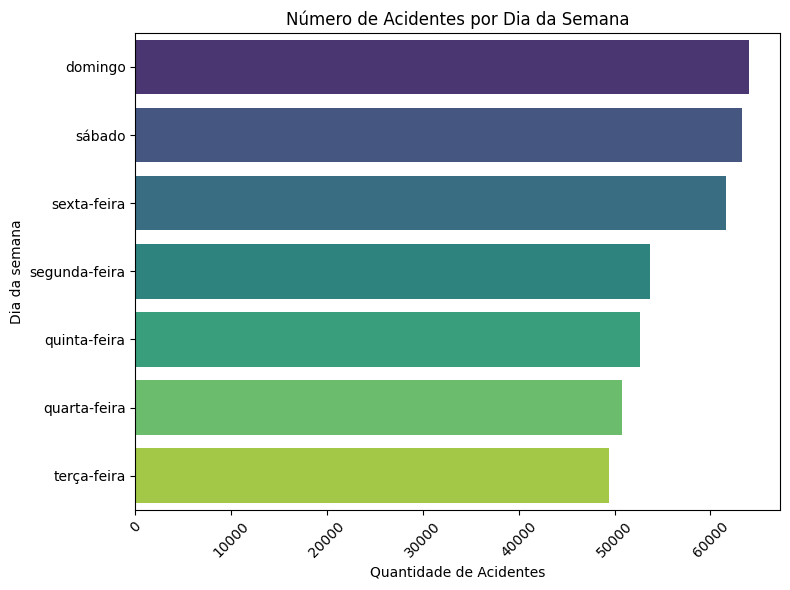

In [ ]:
plt.figure(figsize=(8, 6))
order = df2['dia_semana'].value_counts().index
sns.countplot(df2["dia_semana"], order=order, palette='viridis')

plt.title('Número de Acidentes por Dia da Semana')
plt.xlabel('Quantidade de Acidentes')
plt.ylabel('Dia da semana')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-94-3083358643.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df2["horario"], order=order, palette='viridis')


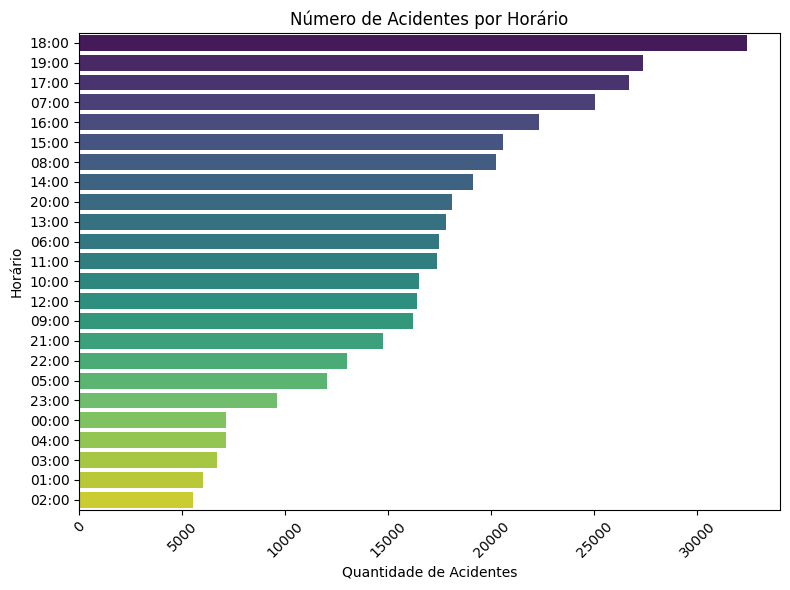

In [ ]:
plt.figure(figsize=(8, 6))
order = df2['horario'].value_counts().index
sns.countplot(df2["horario"], order=order, palette='viridis')

plt.title('Número de Acidentes por Horário')
plt.xlabel('Quantidade de Acidentes')
plt.ylabel('Horário')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-95-4044805564.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df2["faixa_horaria"], order=order, palette='viridis')


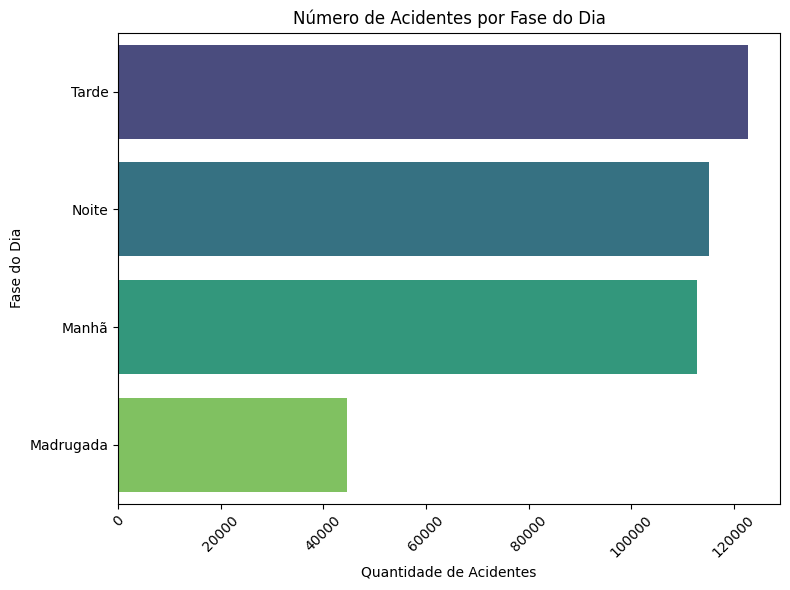

In [ ]:
plt.figure(figsize=(8, 6))
order = df2['faixa_horaria'].value_counts().index
sns.countplot(df2["faixa_horaria"], order=order, palette='viridis')

plt.title('Número de Acidentes por Fase do Dia')
plt.xlabel('Quantidade de Acidentes')
plt.ylabel('Fase do Dia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
result = (
    df.groupby(['dia_semana', 'horario'])
    .size()
    .reset_index(name='quantidade')
    .sort_values(by='quantidade', ascending=False)
)

print(result.head(1))  # Dia e horário com o maior número de acidentes

     dia_semana   horario  quantidade
5333     sábado  19:00:00        1697


## 4.2) Respondendo a pergunta: "Quais são os estados brasileiros com os maiores números de acidentes envolvendo vítimas fatais?"

In [ ]:
# Nome da planilha (confira o nome correto no seu Excel)
sheet_name = 'BRASIL E UFs'  # Altere conforme o nome real da aba

# Carregar o arquivo XLS do último censo para termos uma estimativa próxima da população de cada estado
df_censo = pd.read_excel('/content/POP2022_Brasil_e_UFs.xls', sheet_name='BRASIL E UFs', skiprows=1,nrows=33,usecols=[0,2])

# Nome correto da coluna com os nomes dos estados
coluna_uf = 'BRASIL E UNIDADES DA FEDERAÇÃO'

# Lista das Unidades Federativas válidas + Distrito Federal
ufs_validas = [
    'Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal',
    'Espírito Santo', 'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul',
    'Minas Gerais', 'Pará', 'Paraíba', 'Paraná', 'Pernambuco', 'Piauí',
    'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul', 'Rondônia',
    'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins'
]

# Filtrar o DataFrame para manter apenas as UFs desejadas
df_censo = df_censo[df_censo[coluna_uf].isin(ufs_validas)]

df_censo.head(27)

,BRASIL E UNIDADES DA FEDERAÇÃO,POPULAÇÃO
2,Rondônia,1616379
3,Acre,829780
4,Amazonas,3952262
5,Roraima,634805
6,Pará,8442962
7,Amapá,774268
8,Tocantins,1584306
10,Maranhão,6800605
11,Piauí,3270174
12,Ceará,8936431


In [ ]:
# Salva arquivo Censo no Data Lake
df_censo.to_csv(datalake_raw_dir / censo, index=False)

In [ ]:
# Cria metadados para o arquivo do Censo
metadata = {
    'arquivo': censo,
    'descricao': 'Censo populacional Brasil 2022',
    'formato': 'xls',
    'colunas': df_censo.columns.tolist(),
    'fonte': 'IBGE',
    'origem': 'https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Previa_da_Populacao/POP2022_Brasil_e_UFs.xls',
    'data_coleta': date.today().strftime('%Y-%m-%d')
}

with open(datalake_metadata_dir / 'POP2022_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

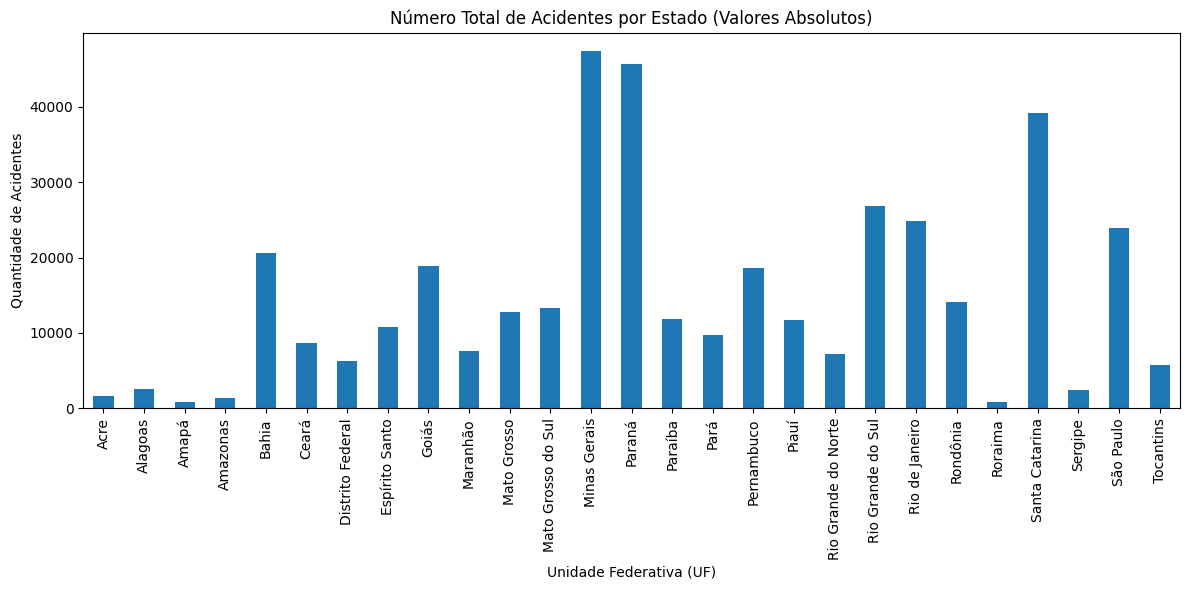

In [ ]:
# Gráfico 1: Total de acidentes por estado (valores absolutos)
acidentes_por_estado = df2['uf'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
acidentes_por_estado.plot(kind='bar')
plt.title('Número Total de Acidentes por Estado (Valores Absolutos)')
plt.xlabel('Unidade Federativa (UF)')
plt.ylabel('Quantidade de Acidentes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

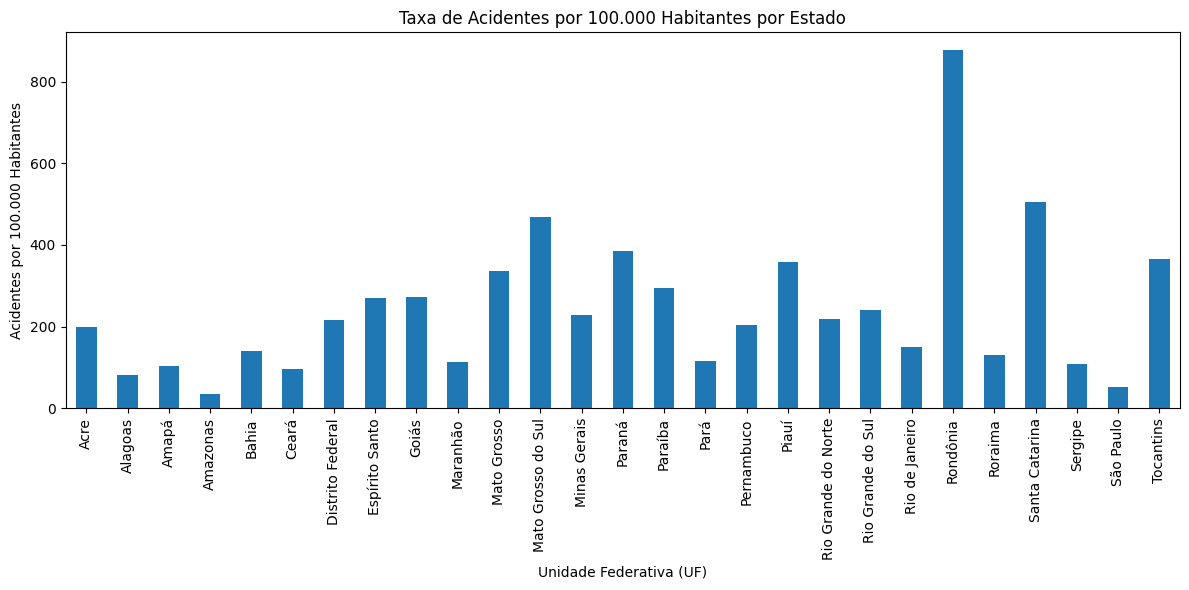

In [ ]:
# Gráfico 2: Acidentes por 100.000 habitantes
# Montar um dicionário: UF → População
df_censo.columns
populacao_por_estado = df_censo.set_index('BRASIL E UNIDADES DA FEDERAÇÃO')['POPULAÇÃO']

# Calcular taxa por 100.000 habitantes
taxa_por_100k = (acidentes_por_estado / populacao_por_estado) * 100000

plt.figure(figsize=(12, 6))
taxa_por_100k.plot(kind='bar')
plt.title('Taxa de Acidentes por 100.000 Habitantes por Estado')
plt.xlabel('Unidade Federativa (UF)')
plt.ylabel('Acidentes por 100.000 Habitantes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
acidentes_vitimas_fatais_df = df2[df2['classificacao_acidente'] == 'Com Vítimas Fatais']

acidentes_vitimas_fatais_df.head()

,dia_semana,horario,uf,causa_principal,causa_acidente,tipo_acidente,classificacao_acidente,sentido_via,condicao_metereologica,tipo_pista,tracado_via,tipo_veiculo,tipo_envolvido,hora_int,faixa_horaria
0,segunda-feira,00:00,Rio de Janeiro,Sim,Reação tardia ou ineficiente do condutor,Colisão com objeto,Com Vítimas Fatais,Decrescente,Céu Claro,Dupla,Reta,Motocicleta,Condutor,0,Madrugada
187,segunda-feira,04:00,Piauí,Sim,Manobra de mudança de faixa,Tombamento,Com Vítimas Fatais,Decrescente,Céu Claro,Simples,Reta,Motocicleta,Condutor,4,Madrugada
188,segunda-feira,04:00,Piauí,Sim,Manobra de mudança de faixa,Tombamento,Com Vítimas Fatais,Decrescente,Céu Claro,Simples,Reta,Caminhão,Condutor,4,Madrugada
189,segunda-feira,04:00,Piauí,Sim,Manobra de mudança de faixa,Queda de ocupante de veículo,Com Vítimas Fatais,Decrescente,Céu Claro,Simples,Reta,Motocicleta,Condutor,4,Madrugada
190,segunda-feira,04:00,Piauí,Sim,Manobra de mudança de faixa,Queda de ocupante de veículo,Com Vítimas Fatais,Decrescente,Céu Claro,Simples,Reta,Caminhão,Condutor,4,Madrugada


In [ ]:
acidentes_vitimas_fatais_df.shape[0]

51680

In [ ]:
acidentes_vitimas_fatais_df['dia_semana'].value_counts(normalize=True) * 100

,proportion
dia_semana,
domingo,20.789474
sábado,18.103715
sexta-feira,14.208591
quinta-feira,12.683824
quarta-feira,11.435759
segunda-feira,11.431889
terça-feira,11.346749


In [ ]:
acidentes_vitimas_fatais_df['tipo_veiculo'].value_counts(normalize=True) * 100

,proportion
tipo_veiculo,
Automóvel,27.592879
Motocicleta,23.103715
Caminhão-trator,14.523994
Caminhão,11.124226
Caminhonete,10.940402
Ônibus,2.933437
Camioneta,2.668344
Bicicleta,1.753096
Motoneta,1.652477


In [ ]:
acidentes_vitimas_fatais_df['tipo_envolvido'].value_counts(normalize=True) * 100

,proportion
tipo_envolvido,
Condutor,75.748839
Passageiro,24.251161


In [ ]:
acidentes_vitimas_fatais_df['faixa_horaria'].value_counts(normalize=True) * 100

,proportion
faixa_horaria,
Noite,35.630805
Tarde,24.229876
Manhã,21.629257
Madrugada,18.510062


In [ ]:
fatal_percent = (
    df2.groupby('dia_semana')['classificacao_acidente']
    .apply(lambda x: (x == 'Com Vítimas Fatais').mean() * 100)
    .sort_values(ascending=False)
)

print(fatal_percent)

dia_semana
domingo          16.770467
sábado           14.786952
quinta-feira     12.449906
sexta-feira      11.910207
terça-feira      11.873570
quarta-feira     11.642567
segunda-feira    11.011705
Name: classificacao_acidente, dtype: float64


/tmp/ipython-input-108-3056850163.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2.groupby('dia_semana')['classificacao_acidente']


## 4.3) Perfil típico do acidente com vítimas fatais

In [ ]:
df_fatais = df2[df2['classificacao_acidente'] == 'Com Vítimas Fatais']

# Traçar o perfil mais comum entre os acidentes fatais
perfil_comum = {
    'Tipo de Acidente': df_fatais['tipo_acidente'].mode()[0] if not df_fatais['tipo_acidente'].mode().empty else 'Indefinido',
    'Período do Dia': df_fatais['faixa_horaria'].mode()[0] if not df_fatais['faixa_horaria'].mode().empty else 'Indefinido',
    'Condição Meteorológica': df_fatais['condicao_metereologica'].mode()[0] if not df_fatais['condicao_metereologica'].mode().empty else 'Indefinido',
    'Tipo de Pista': df_fatais['tipo_pista'].mode()[0] if not df_fatais['tipo_pista'].mode().empty else 'Indefinido',
    'Traçado da Via': df_fatais['tracado_via'].mode()[0] if not df_fatais['tracado_via'].mode().empty else 'Indefinido'
}

# Exibir o perfil
for item, valor in perfil_comum.items():
    print(f"{item}: {valor}")

Tipo de Acidente: Colisão frontal
Período do Dia: Noite
Condição Meteorológica: Céu Claro
Tipo de Pista: Simples
Traçado da Via: Reta


# Referências

[1] Dados Abertos da PRF: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf

[2] Registro Nacional Sinistros: https://www.gov.br/transportes/pt-br/assuntos/transito/arquivos-senatran/docs/renaest

[3] Estudo Confederação Nacional de transito (2007-2017): https://cnt.org.br/acidentes-rodoviarios-infraestrutura

[4] Estudo Ipea (2014): https://www.ipea.gov.br/portal/mestrado-profissional-em-politicas-publicas-e-desenvolvimentodesafios/index.php?option=com_content&view=article&id=3211&catid=29&Itemid=34

[5] Portal do Transito:
https://www.portaldotransito.com.br/noticias/fiscalizacao-e-legislacao/estatisticas/numero-de-mortes-nas-rodovias-federais-cresce-10-em-2024/

[6] Instituto Brasileiro de Geografia e Estatística, Censo 2022: https://www.ibge.gov.br/estatisticas/sociais/saude/22827-censo-demografico-2022.html

[7] Plano Nacional de Redução de Mortes e Lesões no Trânsito (PNATRANS): https://www.gov.br/participamaisbrasil/revisao-pnatrans